In [1]:
!pip -q uninstall -y numpy torch torchvision torchaudio
!pip -q install numpy==1.26.4
!pip -q install torch==2.4.1+cu121 torchvision==0.19.1+cu121 torchaudio==2.4.1+cu121 --index-url https://download.pytorch.org/whl/cu121
!pip -q install opencv-python-headless==4.10.0.84 transformers==4.44.2 timm==1.0.9


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 112.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.4 requires torch<2.9,>=1.10, which is not installed.
fastai 2.8.4 requires torchvision>=0.11, which is not installed.
sentence-transformers 5.1.0 requires torch>=1.11.0, which is not installed.
peft 0.17.1 requires torch>=1.13.0, which is not installed.
accelerate 1.10.1 requires torch>=2.0.0, which is not installed.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is in

#Redémarrer le runtime entre ces deux cellules

In [1]:
import numpy, torch, torchvision, cv2
print("numpy", numpy.__version__)
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("cv2", cv2.__version__)


numpy 1.26.4
torch 2.4.1+cu121
torchvision 0.19.1+cu121
cv2 4.10.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

BASE = "/content/drive/MyDrive"
NPZ_DIR = f"{BASE}/processed_npz"
!ls -lah "{NPZ_DIR}" | head -n 20


Mounted at /content/drive
total 191M
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swing_0001.npz
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swing_0002.npz
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swing_0003.npz
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swing_0004.npz
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swing_0005.npz
-rw------- 1 root root 1.5M Sep 16 23:00 backhand_swing_0006.npz
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swing_0007.npz
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swing_0008.npz
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swing_0009.npz
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swing_0010.npz
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swing_0011.npz
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swing_0012.npz
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swing_0013.npz
-rw------- 1 root root 1.3M Sep 16 23:00 backhand_swing_0014.npz
-rw------- 1 root root 1.4M Sep 16 23:00 backhand_swi

In [3]:
%%writefile dataset_colab.py
import numpy as np, torch
from torch.utils.data import Dataset
import torchvision.transforms as T

TCLIP = 8

class TennisDataset(Dataset):
    def __init__(self, files, train=True):
        self.files = [str(p) for p in files]
        self.train = train
        self.train_tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(192, scale=(0.8, 1.0)),
            T.ColorJitter(0.2, 0.2, 0.2, 0.1),
            T.RandomGrayscale(p=0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225]),
        ])
        self.eval_tf = T.Compose([
            T.ToPILImage(),
            T.Resize((192, 192)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        d = np.load(self.files[idx])
        X, y = d["X"], int(d["y"])      # X: [T,H,W,C]
        # échantillonnage à 8 frames
        idxs = np.linspace(0, X.shape[0]-1, TCLIP).astype(int)
        tf = self.train_tf if self.train else self.eval_tf
        frames = [tf(X[i]) for i in idxs]
        video = torch.stack(frames, dim=0)   # [T=8,C,H,W]
        return video, y


Writing dataset_colab.py


In [4]:
%%writefile train_colab.py
import torch, csv
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from pathlib import Path
from transformers import TimesformerForVideoClassification
from dataset_colab import TennisDataset

BASE = "/content/drive/MyDrive"
NPZ_DIR = Path(f"{BASE}/processed_npz")
HIST_CSV = Path(BASE) / "history.csv"

files = sorted(NPZ_DIR.glob("*.npz"))
assert len(files) > 0, "Aucun .npz trouvé dans processed_npz"

# split 70/15/15
n = len(files); n_tr = int(0.7*n); n_val = int(0.15*n); n_te = n - n_tr - n_val
tr, val, te = random_split(files, [n_tr, n_val, n_te], generator=torch.Generator().manual_seed(42))

train_ds = TennisDataset(tr, train=True)
val_ds   = TennisDataset(val, train=False)
test_ds  = TennisDataset(te, train=False)

BATCH, ACCUM = 4, 4
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TimesformerForVideoClassification.from_pretrained(
    "facebook/timesformer-base-finetuned-k400",
    num_labels=2, ignore_mismatched_sizes=True
).to(device)

# 8 frames, 192px
model.config.num_frames = 8
model.config.image_size = 192
model.gradient_checkpointing_enable()

EPOCHS_LP, EPOCHS_FT = 5, 25

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_LP+EPOCHS_FT, eta_min=1e-5)
scaler = torch.amp.GradScaler("cuda")

# init CSV
with open(HIST_CSV, "w", newline="") as f:
    csv.writer(f).writerow(["epoch","phase","train_loss","val_acc","best_val"])

# linear probe
for p in model.parameters(): p.requires_grad = False
for p in model.classifier.parameters(): p.requires_grad = True

def train_one_epoch(loader):
    model.train(); optimizer.zero_grad(set_to_none=True)
    tot, nsteps = 0.0, 0
    for step, (X, y) in enumerate(loader, 1):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with torch.amp.autocast("cuda"):
            out = model(X)                          # X: [B,8,C,192,192]
            loss = criterion(out.logits, y) / ACCUM
        scaler.scale(loss).backward()
        if step % ACCUM == 0:
            scaler.step(optimizer); scaler.update()
            optimizer.zero_grad(set_to_none=True)
        tot += loss.item()*ACCUM; nsteps += 1
    return tot/nsteps if nsteps>0 else 0.0

def evaluate(loader):
    model.eval(); correct=total=0
    with torch.no_grad(), torch.amp.autocast("cuda"):
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).logits.argmax(1)
            correct += (pred==y).sum().item(); total += y.size(0)
    return 100*correct/total if total>0 else 0.0

best = 0.0; best_path = str(Path(BASE) / "best_timesformer.pt")

for epoch in range(1, EPOCHS_LP+1):
    tl = train_one_epoch(train_loader)
    acc = evaluate(val_loader)
    if acc > best: best = acc; torch.save(model.state_dict(), best_path)
    with open(HIST_CSV,"a",newline="") as f:
        csv.writer(f).writerow([epoch,"LP",f"{tl:.6f}",f"{acc:.2f}",f"{best:.2f}"])
    print(f"[LP] {epoch}/{EPOCHS_LP} loss {tl:.4f} val {acc:.2f} best {best:.2f}")
    scheduler.step()

for p in model.parameters(): p.requires_grad = True

for epoch in range(1, EPOCHS_FT+1):
    tl = train_one_epoch(train_loader)
    acc = evaluate(val_loader)
    if acc > best: best = acc; torch.save(model.state_dict(), best_path)
    with open(HIST_CSV,"a",newline="") as f:
        csv.writer(f).writerow([EPOCHS_LP+epoch,"FT",f"{tl:.6f}",f"{acc:.2f}",f"{best:.2f}"])
    print(f"[FT] {epoch}/{EPOCHS_FT} loss {tl:.4f} val {acc:.2f} best {best:.2f}")
    scheduler.step()

model.load_state_dict(torch.load(best_path, map_location=device))
test_acc = evaluate(test_loader)
print(f"Test acc {test_acc:.2f}  |  Best val {best:.2f}")


Writing train_colab.py


In [10]:
import os, gc, torch
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
gc.collect(); torch.cuda.empty_cache()


In [5]:
!python train_colab.py

config.json: 22.7kB [00:00, 59.0MB/s]
pytorch_model.bin: 100% 486M/486M [00:07<00:00, 61.6MB/s]
Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
[LP] 1/5 loss 0.6917 val 44.44 best 44.44
[LP] 2/5 loss 0.6688 val 27.78 best 44.44
[LP] 3/5 loss 0.6319 val 27.78 best 44.44
[LP] 4/5 loss 0.6043 val 55.56 best 55.56
[LP] 5/5 loss 0.586

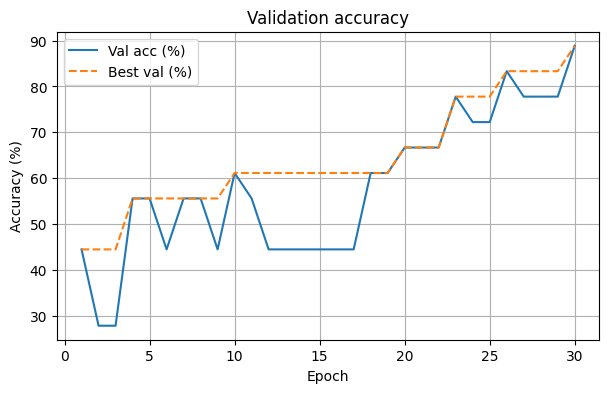

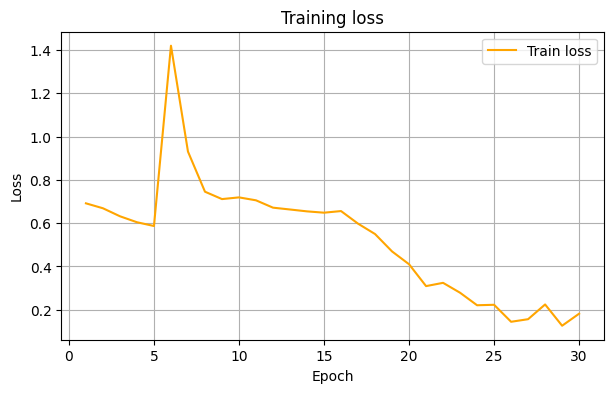

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive"
hist = pd.read_csv(f"{BASE}/history.csv")

plt.figure(figsize=(7,4))
plt.plot(hist["epoch"], hist["val_acc"], label="Val acc (%)")
plt.plot(hist["epoch"], hist["best_val"], label="Best val (%)", linestyle="--")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Validation accuracy")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
plt.plot(hist["epoch"], hist["train_loss"], label="Train loss", color="orange")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training loss")
plt.legend(); plt.grid(True); plt.show()
